In [3]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../../Lessons/Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [12]:
# add your imports and settings here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import transforms

from torchinfo import summary
from sklearn.metrics import accuracy_score
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib.pyplot import imshow
import seaborn as sns

from introdl.utils import get_device, load_results, load_model, config_paths_keys, summarizer
from introdl.idlmam import train_simple_network, visualize2DSoftmax
from introdl.visul import plot_training_metrics

from sklearn.model_selection import train_test_split

from introdl.utils import config_paths_keys

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']


MODELS_PATH=.
DATA_PATH=.
TORCH_HOME=.
HF_HOME=.


### Loading Data

The data is an image type, not a tensor type. We need to transform data to tensor

In [16]:
mnist_data_train = torchvision.datasets.MNIST(root=DATA_PATH, train=True,
    download=True)

mnist_data_test = torchvision.datasets.MNIST(root=DATA_PATH, train=False,
    download=True)

x_example, y_example = mnist_data_train[0]
type(x_example)


PIL.Image.Image

Torchvision has an argument where we can transform during the assignment. Use transforms.ToTensor() method

In [18]:
mnist_data_train = torchvision.datasets.MNIST(root=DATA_PATH, train=True,
    download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST(root=DATA_PATH, train=False,
    download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(x_example.shape)  

torch.Size([1, 28, 28])


imshow expects only height and width dimensions as arguments and needs a cmap of gray to show this image

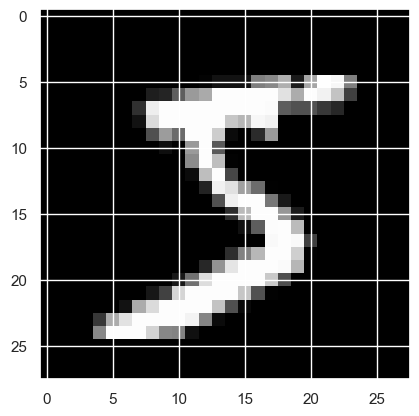

In [19]:
imshow(x_example[0,:], cmap='gray')

"stack" three versions of this image on top of each other. This essentially gives the image a color because this dimension now has three channels that can determine the color

In [21]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]],
    dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


We can't show the N dimension in imshow, and the structure of our tensor (N, C, W, H) is different than what imshow accepts (W, H, C). We can use the permute method to enter our tensor into the imshow function in the dimension order that imshow will accept. 1,2,0 will give shape the tensor in order of W, H, C. 

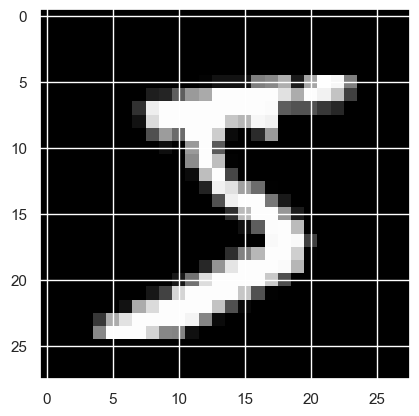

In [22]:
imshow(x_as_color.permute(1,2,0))

We still see a white image because the original image was white. To make it colored, we need to change values in the color layers. 

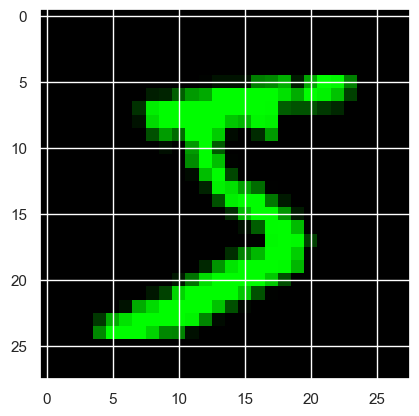

In [24]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 
x_as_color[2,:] = 0
imshow(x_as_color.permute(1,2,0))

In this example, three different images are stacked onto each other. This is obviously wrong

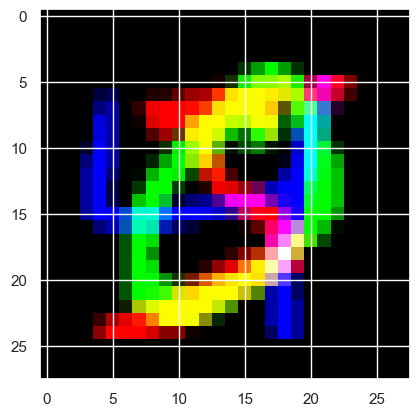

In [25]:
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
x1, x2, x3 = x1[0], x2[0], x3[0] # drop labels
x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

The order of these dimensions is important, shuffling will remove meaning. 

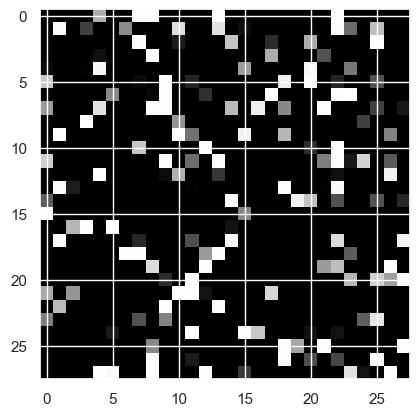

In [26]:
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)
imshow(x_shuffled[0,:], cmap='gray')

## Convolution

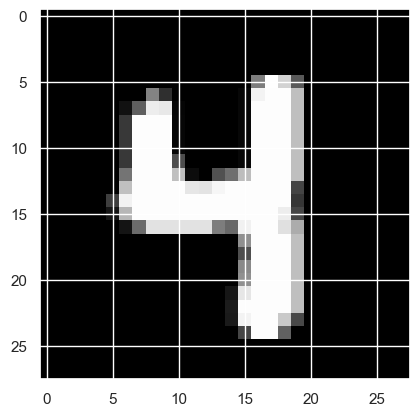

In [34]:
from scipy.signal import convolve
img_indx = 58
img = mnist_data_train[img_indx][0][0,:]
imshow(img, vmin=0, vmax=1, cmap='gray')

Blur the image:

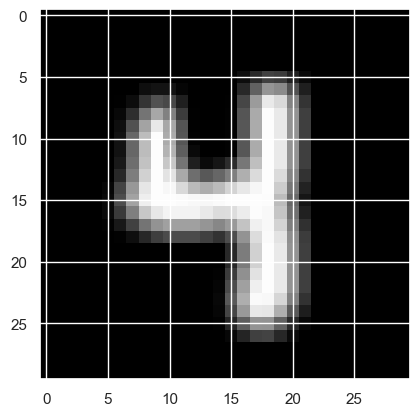

In [32]:
blur_filter = np.asarray(
    [[1,1,1],
    [1,1,1],
    [1,1,1]
    ])/9.0
blurry_img = convolve(img, blur_filter)
imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Edge Detection

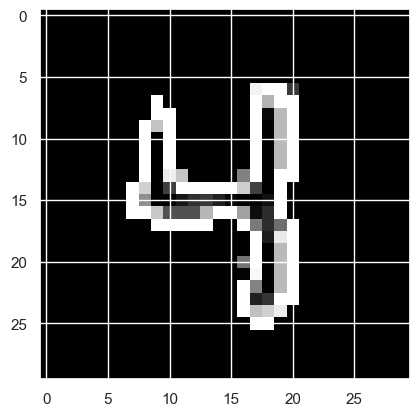

In [36]:
edge_filter = np.asarray(
    [[-1,-1,-1], 
    [-1, 8,-1],
    [-1,-1,-1]]
)

edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

Look for edges at a horizontal angle

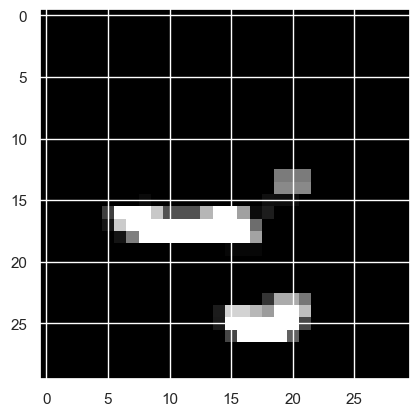

In [37]:
h_edge_filter = np.asarray(
    [[-1,-1,-1], 
     [0, 0,0],
     [1, 1, 1]]
)

h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

## Making a CNN

In [38]:
device = get_device()
B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

In [61]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(D, 256),
            nn.Tanh(),
            nn.Linear(256, classes),
        )
        
    def forward(self, x):
        return self.model(x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(C, filters, K, padding=K//2),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(filters*D, classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [50]:
D = 28*28
C = 1
classes = 10
filters = 16
K = 3

model_linear = LinearModel()
model_cnn = CNN()

loss_func = nn.CrossEntropyLoss()

cnn_results = train_simple_network(model_cnn, loss_func,
    mnist_train_loader, test_loader=mnist_test_loader,
    score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

fc_results = train_simple_network(model_linear, loss_func,
    mnist_train_loader, test_loader=mnist_test_loader,
    score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

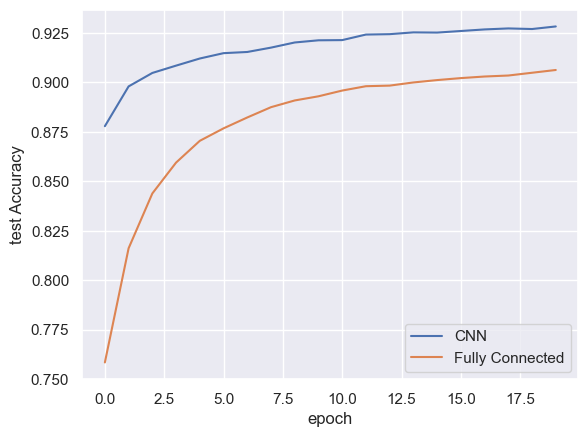

In [51]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results,
label='Fully Connected')

The CNN is better off the start. We still aren't taking advantage of the spatial nature of this data. Was fine for this problem because the data set we used had every image centered, but for others this could be an issue when using a linear layer, which looks for data at a very specific location|

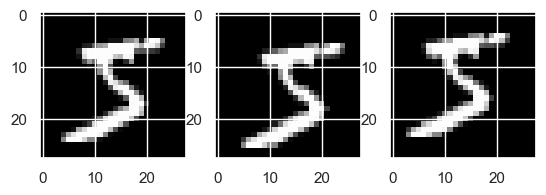

In [56]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0) 
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)

f, axarr = plt.subplots(1,3) 
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

These are all clearly the same image and number. But because we changed their coordinates in the image relative to each other, our model will struggle with them 

In [58]:
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():
        w, h = img.shape 
        
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
        
    x = img.reshape(1,-1,w,h)
    logits = model(x) 
    y_hat = F.softmax(logits, dim=1) 
    return y_hat.detach().numpy().flatten()

img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print('Org Img Class {} Prob: '.format(correct_class),
    img_pred[correct_class])
print('Lower Right Img Class {} Prob: '.format(correct_class),
    img_lr_pred[correct_class])
print('Uper Left Img Class {} Prob: '.format(correct_class),
    img_ul_pred[correct_class])
    

Org Img Class 5 Prob:  0.78024405
Lower Right Img Class 5 Prob:  0.3721057
Uper Left Img Class 5 Prob:  0.38345063


Pooling will fix this issue

In [68]:
class CNN_Pool(nn.Module):
    def __init__(self):
        super(CNN_Pool, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(C, filters, 3, padding=3//2),
            nn.Tanh(),
            nn.Conv2d(filters, filters, 3, padding=3//2),
            nn.Tanh(),
            nn.Conv2d(filters, filters, 3, padding=3//2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(filters, 2*filters, 3, padding=3//2),
            nn.Tanh(),
            nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
            nn.Tanh(),
            nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(2*filters*D//(4**2), classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [69]:
model_cnn_pool = CNN_Pool()
cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func,
    mnist_train_loader, test_loader=mnist_test_loader,
    score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

In [70]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print('Org Img Class {} Prob: '.format(correct_class) ,
    img_pred[correct_class])
print('Lower Right Img Class {} Prob: '.format(correct_class) ,
    img_lr_pred[correct_class])
print('Uper Left Img Class {} Prob: '.format(correct_class) ,
    img_ul_pred[correct_class])

Org Img Class 5 Prob:  0.7122756
Lower Right Img Class 5 Prob:  0.78642094
Uper Left Img Class 5 Prob:  0.8795824


<Axes: xlabel='epoch', ylabel='test Accuracy'>

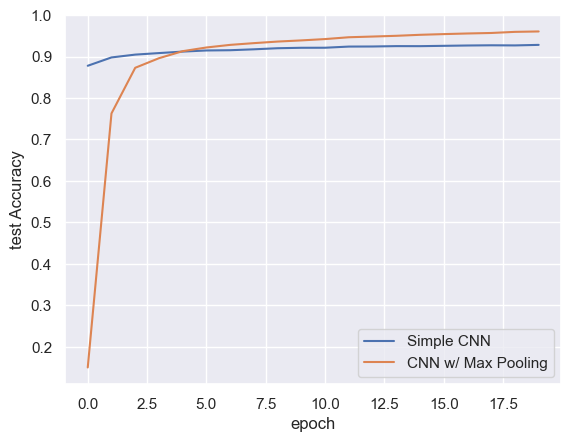

In [71]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results,
    label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool,
    label='CNN w/ Max Pooling')

## Data Augmentation

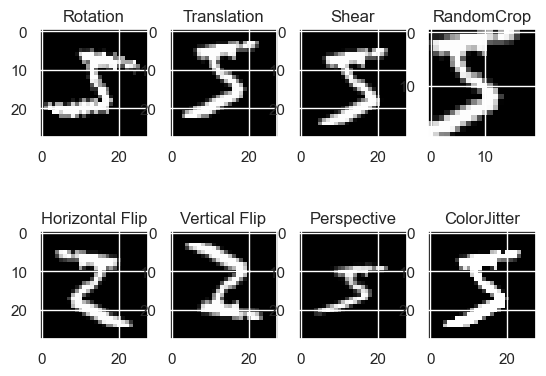

In [72]:
sample_transforms = {
    'Rotation' : transforms.RandomAffine(degrees=45),
    'Translation' : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    'Shear': transforms.RandomAffine(degrees=0, shear=45),
    'RandomCrop' : transforms.RandomCrop((20,20)),
    'Horizontal Flip' : transforms.RandomHorizontalFlip(p=1.0),
    'Vertical Flip': transforms.RandomVerticalFlip(p=1.0),
    'Perspective': transforms.RandomPerspective(p=1.0),
    'ColorJitter' : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}

pil_img = transforms.ToPILImage()(img)

f, axarr = plt.subplots(2,4)

for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

Augmenting data can increase the accuracy and robustness of a model

In [74]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05),
        scale=(0.98, 1.02)),
    transforms.ToTensor(),
    ])
test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST(root=DATA_PATH, train=True,
    transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST(root=DATA_PATH, train=False,
    transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,
    batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B,
    num_workers=5)

In [75]:
model_cnn_pool = CNN_Pool()

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool,
    loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t,
    score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

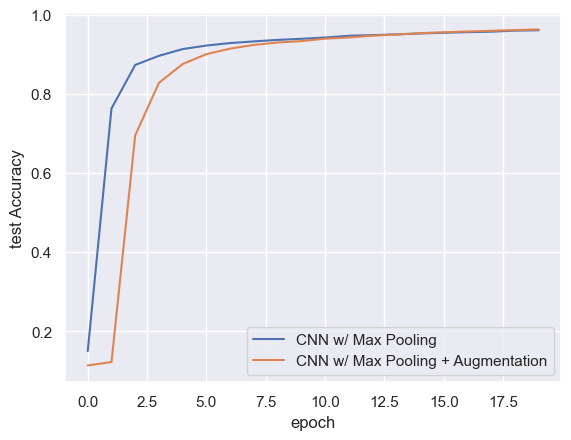

In [76]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool,
    label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy',
    data=cnn_results_with_pool_augmented,
    label='CNN w/ Max Pooling + Augmentation')